In [22]:
import os
import sys
import yaml
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *
import requests
from ibm_ai_openscale.utils import get_instance_guid
import ibm_watson_machine_learning
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord
import ibm_watson_openscale


with open("../credentials.yaml") as stream:
    try:
        credentials = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


with open("../metadata.yaml") as stream:
    try:
        metadata = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


service_credentials = {
    "apikey": credentials["apikey"],
    "url": "https://api.aiopenscale.cloud.ibm.com",
}

DEPLOYMENT_UID = metadata["deployment_uid"]
MODEL_UID = metadata["model_uid"]
MODEL_NAME = metadata["project_name"] + "_" + metadata["project_version"]
SPACE_ID = credentials["space_id"]
WOS_GUID = get_instance_guid(api_key=service_credentials["apikey"])
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": service_credentials["apikey"],
    "url": "https://api.aiopenscale.cloud.ibm.com",
}

if WOS_GUID is None:
    print("Watson OpenScale GUID NOT FOUND")
else:
    print(WOS_GUID)
    


wml_credentials = {"url": credentials["url"], "apikey": credentials["apikey"]}

wml_client = ibm_watson_machine_learning.APIClient(wml_credentials)

wml_credentials = {
    "url": credentials["url"],
    "apikey": credentials["apikey"],
    "instance_id": "wml_local",
}

wml_client.set.default_space(SPACE_ID)

authenticator = IAMAuthenticator(apikey=credentials["apikey"])
wos_client = ibm_watson_openscale.APIClient(
    authenticator=authenticator, 
    service_url="https://api.aiopenscale.cloud.ibm.com")




7b220d7b-3196-43c3-8510-a4f710021a04
DEPRECATED!! Python 3.6 framework is deprecated and will be removed on Jan 20th, 2021. It will be read-only mode starting Nov 20th, 2020. i.e you won't be able to create new assets using this client. Use Python 3.7 instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html


In [23]:

for deployment in wml_client.deployments.get_details()['resources']:
    if DEPLOYMENT_UID in deployment['metadata']['id']:

        scoring_endpoint = deployment['entity']['status']['online_url']['url']
        
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e02e481d-4e56-470f-baa9-ae84a583c0a8/predictions


In [44]:
wos_client.subscriptions.show()

f29e4cfc-3aab-458a-b703-fabc265f43a3,Rain_aus_v0.3,7b220d7b-3196-43c3-8510-a4f710021a04,e02e481d-4e56-470f-baa9-ae84a583c0a8,Rain_aus_v0.3-Deployment,974615e0-4c06-40a3-af1f-944192f7e472,active,2021-04-04 21:23:38.668000+00:00,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05


In [24]:
df_data = pd.read_csv("../data/weatherAUS_processed.csv")

X = df_data.iloc[:, :-1]
y = df_data[df_data.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, random_state=1337
)

payload_scoring = {
    "input_data": [
        {
            "fields": X.columns.to_numpy().tolist(),
            "values": X_test.to_numpy().tolist(),
        }
    ]
}

In [25]:
scoring_response = wml_client.deployments.score(DEPLOYMENT_UID, payload_scoring)

# scoring_response

In [26]:
pred_values = np.squeeze(scoring_response["predictions"][0]["values"])
y_pred_values = [i[0] for i in pred_values]

def comb_eval(y, y_pred):
    acc = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    return {"accuracy": acc, "recall": recall, "precision": precision, "f1": f1}

eval = comb_eval(y_test, y_pred_values)
print(eval)


{'accuracy': 0.8513289036544851, 'recall': 0.9693654266958425, 'precision': 0.8543876567020251, 'f1': 0.9082521783700666}


In [45]:
subscription_id = 'bb7a45c3-15ad-4932-aeb8-8d32d54b8b05'

payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
print("Payload data set id:", payload_data_set_id)




Payload data set id: f4791725-24f8-4a00-9c13-b331ebca47f6


In [46]:
print('Logging')
records = [PayloadRecord(request=payload_scoring, response=scoring_response, response_time=72)]
store_record_info = wos_client.data_sets.store_records(payload_data_set_id, records)


Logging


In [47]:
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result

feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")
    sys.exit(1)

data = X_test.to_dict('records')

wos_client.data_sets.store_records(
    feedback_dataset_id, 
    request_body=data, 
    background_mode=False,
    header=True,
    delimiter=',',
    csv_max_line_length=1000)

print(wos_client.data_sets.get_records_count(data_set_id=feedback_dataset_id))




 Waiting for end of storing records with request id: fdc33e18-2abd-40a3-9bef-ac9f56346835 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


2529


In [48]:

from ibm_watson_openscale.supporting_classes.enums import *

print('\nData marts: ')
datams = wos_client.data_marts.list().result.data_marts
for d in datams:
    print(d.metadata.id)
datamart_id = d.metadata.id

print('\nService providers: ')
services = wos_client.service_providers.list().result.service_providers
for service in services:
    print(service.metadata.id+" / Name: "+service.entity.name)
service_id = service.metadata.id

#wos_client.subscriptions.show()
#wos_client.data_sets.show()

print('\nSubscriptions: ')
subscriptions = wos_client.subscriptions.list(data_mart_id=datamart_id, service_provider_id=service_id).result.subscriptions
for s in subscriptions:
  print(s.metadata.id+"   "+s.entity.asset.name)
subscription_id = s.metadata.id

print('\n')

payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
print("Payload data set id:", payload_data_set_id)


pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))
if pl_records_count == 0:
    raise Exception("Payload logging did not happen!")



Data marts: 
7b220d7b-3196-43c3-8510-a4f710021a04

Service providers: 
974615e0-4c06-40a3-af1f-944192f7e472 / Name: Rain Aus

Subscriptions: 
bb7a45c3-15ad-4932-aeb8-8d32d54b8b05   Rain_aus_v0.3


Payload data set id: f4791725-24f8-4a00-9c13-b331ebca47f6
Number of records in the payload logging table: 8072


In [62]:
target = ibm_watson_openscale.base_classes.watson_open_scale_v2.Target(
            target_type=TargetTypes.SUBSCRIPTION,
            target_id=subscription_id
        )
parameters =  {
            "min_feedback_data_size": 200
        }
thresholds =  [{
        "metric_id": "area_under_roc",
        "type": "lower_limit",
        "value": 0.75
    }]
wos_client.monitor_instances.create(
        data_mart_id=datamart_id,
        background_mode=False,
        monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
        target=target,
        parameters=parameters,
        thresholds=thresholds
)

ApiException: Error: Resource could not be created because of conflict with existing resource `5ddff093-25fa-44f8-abae-fd29659fd0d0` of type `monitor_instance`, Code: 409 , X-global-transaction-id: ODQ3YmE5NmEtMTdmZC00MDA0LWIyZDQtMDQ3YTViNjk3YmM2

In [89]:
# wos_client.data_sets.print_records_schema(data_set_id=payload_data_set_id)

In [76]:
# records = [PayloadRecord(request=payload_scoring, response=scoring_response, response_time=72)]


x = wos_client.data_sets.show_records(data_set_id=payload_data_set_id)
x

0.0,None,0.0,0.0,33.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1,0.0,0.0,0.0,11.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.9300195977465232,0.0,1012.7,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,37.0,0.0,0.0,None,None,1007.9,0.0,0.0,0.0,11.0,0.0,1.0,41.5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,29.6,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,21.7,0.0,0.0,None,0.0,0.0,0.0,1.0,19.0,0.0,0.0,42.6,0.0,"[0.06998040225347664, 0.9300195977465232]",0.0,0.0
0.0,None,0.0,0.0,37.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-10,0.0,0.0,0.0,38.0,0.0,None,2021-04-16T18:16:34.189Z,1.0,0.0,0.0,0.0,0.0,None,0.9070971403524445,0.0,1012.3,0.0,0.0,0.0,None,0.0,0.0,1.0,0.0,1,0.0,63.0,0.0,0.0,None,None,1009.8,0.0,0.0,0.0,17.0,0.0,1.0,31.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25.1,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,18.9,0.0,0.0,None,0.0,0.0,0.0,0.0,13.0,0.0,0.0,33.6,0.0,"[0.09290285964755546, 0.9070971403524445]",0.0,0.0
0.0,None,0.0,0.0,46.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-100,0.0,0.0,0.0,28.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.9385864418537337,0.0,1015.3,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,55.0,0.0,0.0,None,None,1011.7,0.0,0.0,0.0,19.0,0.0,1.0,32.8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,26.5,e02e481d-4e56-470f-baa9-ae84a583c0a8,1.0,22.5,0.0,0.0,None,0.0,0.0,0.0,0.0,26.0,0.0,0.0,33.4,0.0,"[0.06141355814626584, 0.9385864418537337]",0.0,0.0
0.0,None,0.0,0.0,35.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1000,0.0,0.0,0.0,48.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.9271085318055369,0.0,1025.0,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,57.0,1.0,0.0,None,None,1022.6,0.0,0.0,0.0,20.0,0.0,1.0,22.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,18.7,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,15.6,0.0,0.0,None,0.0,0.0,0.0,0.0,20.0,0.0,0.0,23.3,0.0,"[0.07289146819446261, 0.9271085318055369]",0.0,1.0
0.0,None,0.0,0.0,39.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1001,0.0,0.0,0.0,25.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.9116252930229102,0.0,1018.0,0.0,1.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,63.0,1.0,0.0,None,None,1015.6,0.0,0.0,0.0,11.0,0.0,1.0,24.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,7.7,0.0,1.0,None,0.0,0.0,0.0,0.0,19.0,0.0,0.0,27.1,0.0,"[0.08837470697708953, 0.9116252930229102]",0.0,0.0
0.0,None,0.0,0.0,67.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1002,0.0,0.0,0.0,31.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.7912716456969836,0.0,1010.9,0.0,0.0,1.0,None,1.0,0.0,0.0,0.0,1,0.0,54.0,0.0,0.0,None,None,1008.5,0.0,0.0,0.0,6.0,0.0,1.0,20.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.5,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,7.6,0.0,0.0,None,1.0,0.0,0.0,0.0,20.0,0.0,0.0,22.4,0.0,"[0.20872835430301628, 0.7912716456969836]",0.0,0.0
1.0,None,0.0,0.0,33.0,None,1.4,42d452fc-ec73-4df7-a801-6c9cef35743b-1003,0.0,0.0,0.0,29.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.813657037411074,0.0,1010.9,1.0,0.0,0.0,None,1.0,0.0,0.0,0.0,1,0.0,53.0,0.0,0.0,None,None,1005.6,0.0,0.0,0.0,4.0,0.0,0.0,28.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.1,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,12.7,0.0,0.0,None,0.0,0.0,0.0,0.0,9.0,0.0,0.0,29.1,0.0,"[0.18634296258892602, 0.813657037411074]",0.0,0.0
0.0,None,0.0,0.0,39.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1004,0.0,0.0,0.0,59.0,1.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.7670154451086266,0.0,1010.0,0.0,1.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,72.0,0.0,0.0,None,None,1006.4,0.0,0.0,0.0,15.0,0.0,1.0,33.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.2,e02e481d-4e56-470f-baa9-ae84a583c0a8,0.0,27.5,0.0,0.0,None,0.0,0.0,0.0,0.0,22.0,0.0,0.0,34.1,0.0,"[0.23298455489137349, 0.7670154451086266]",0.0,0.0
0.0,None,0.0,0.0,41.0,None,0.0,42d452fc-ec73-4df7-a801-6c9cef35743b-1005,0.0,0.0,0.0,33.0,0.0,None,2021-04-16T18:16:34.189Z,0.0,0.0,0.0,0.0,0.0,None,0.8790265877732463,0.0,1008.6,0.0,0.0,0.0,None,0.0,0.0,0.0,0.0,1,0.0,29.0,0.0,0.0,None,None,1008.1,0.0,0.0,0.0,20.0,0.0,

In [77]:
records2 = wos_client.data_sets.get_list_of_records(data_set_id=payload_data_set_id,
                                                   output_type=ResponseTypes.PANDAS
   )
df = records2.result

# import pandas as pd
# import numpy as np
# # df.to_csv('res.csv',index=False)
# df['RainTomorrow'] = np.random.randint(2, size=df.shape[0])#.toarray().tolist()
# df.to_csv('res.csv',index=False)



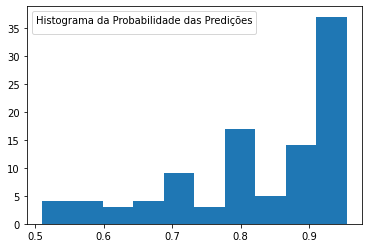

In [78]:
import matplotlib.pyplot as plt


plt.hist(df.prediction_probability)
plt.legend(title='Histograma da Probabilidade das Predições')
plt.show()


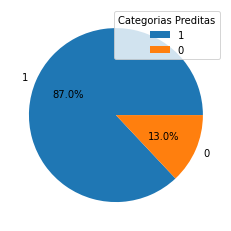

1    87
0    13
Name: prediction, dtype: int64

In [79]:
plt.pie(df.prediction.value_counts(),labels=['1','0'],autopct='%1.1f%%')
plt.legend(title='Categorias Preditas')
plt.show()
df.prediction.value_counts()

In [80]:
ct = pd.crosstab(df.prediction, df.RainToday)
ct

RainToday,0.0,1.0
prediction,,
0,11,2
1,16,71


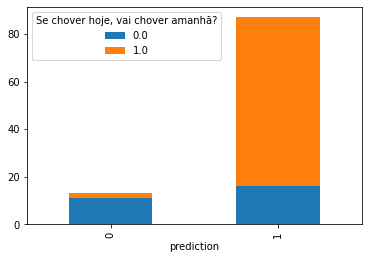

In [81]:
ct.plot.bar(stacked=True)
plt.legend(title='Se chover hoje, vai chover amanhã?')
plt.show()

In [82]:
wos_client.data_sets.get_records_count(payload_data_set_id) # ibm_watson_openscale


8072

In [83]:
monitor_instances_info = wos_client.monitor_instances.show(
    data_mart_id="7b220d7b-3196-43c3-8510-a4f710021a04",
     )


7b220d7b-3196-43c3-8510-a4f710021a04,active,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,quality,2021-04-08 16:25:48.434000+00:00,5ddff093-25fa-44f8-abae-fd29659fd0d0
7b220d7b-3196-43c3-8510-a4f710021a04,active,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,drift,2021-04-05 15:16:56.829000+00:00,9d51655d-1f57-4061-9df4-8ef20b6ebced
7b220d7b-3196-43c3-8510-a4f710021a04,error,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,fairness,2021-04-04 21:30:28.742000+00:00,30bc90c4-8c54-413d-98aa-8d4ff5bb2680
7b220d7b-3196-43c3-8510-a4f710021a04,error,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,explainability,2021-04-04 21:28:01.896000+00:00,dcb0abd5-b476-43c0-ba7f-be93ad250d6f
7b220d7b-3196-43c3-8510-a4f710021a04,active,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,mrm,2021-04-04 21:23:42.492000+00:00,3748dfc5-7236-406b-be1d-1ca2363c9343
7b220d7b-3196-43c3-8510-a4f710021a04,active,bb7a45c3-15ad-4932-aeb8-8d32d54b8b05,subscription,performance,2021-04-04 21:23:42.488000+00:00,570ab6f2-e0e3-4402-bb78-d8de41331a3e
7b220d7b-3196-43c3-8510-a4f710021a04,active,6812f06b-1a26-4eba-93cf-91b520950a74,instance,performance,2021-03-10 18:28:38.861000+00:00,26bb6bb7-d140-4280-8044-63ec11f7af3b


In [84]:
wos_client.monitor_instances.show_metrics(monitor_instance_id='5ddff093-25fa-44f8-abae-fd29659fd0d0')

In [85]:
# wos_client.monitor_instances.delete(
#         background_mode=False,
#         monitor_instance_id='94e582d5-c244-4533-9697-c16046c5fc40'
#      )


In [86]:
monitor_instance_run_info = wos_client.monitor_instances.run(
        background_mode=False,
        monitor_instance_id='5ddff093-25fa-44f8-abae-fd29659fd0d0',
     )




 Waiting for end of monitoring run 65ba74f7-90e3-467a-9468-7892b3a0e488 




error

-------------------------------
 Run failed with status: error 
-------------------------------


Reason: ['code: AIQFS0002E, message: Action `Score Batch` has failed with status code 400; associated message: `{2}`', 'code: AIQGS0099E, message: X has 66 features, but this StandardScaler is expecting 61 features as input.']
